In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from dataset import Dataset
from features import StrategiesSignals
import plotly.graph_objects as go
from backtester import Backtest

In [2]:
TICKER = "BTCUSDT"
data_binance = Dataset()
data = data_binance.get_data(days=90, ticker=TICKER, ts='5m')

In [3]:
data.head(13)

,open,high,low,close,volume
time,,,,,
2021-06-18 00:05:00,38092.97,38094.10,37958.00,37990.00,212.246273
2021-06-18 00:10:00,37990.00,37990.00,37885.01,37984.05,144.074834
2021-06-18 00:15:00,37988.03,38161.70,37984.15,38155.98,223.093488
2021-06-18 00:20:00,38155.99,38202.84,38105.16,38113.86,258.626630
2021-06-18 00:25:00,38113.84,38115.96,38000.00,38004.17,223.131922
2021-06-18 00:30:00,38004.17,38078.82,37992.51,38016.39,138.026927
2021-06-18 00:35:00,38016.39,38116.09,38007.63,38076.01,126.508061
2021-06-18 00:40:00,38076.01,38076.01,38007.88,38009.99,106.806798
2021-06-18 00:45:00,38010.00,38010.00,37939.00,37944.16,123.969974


In [12]:
data['hours'] = data.index.hour
data['days'] = data.index.day_of_year
data['daysWeek'] = data.index.day_of_week

In [13]:
days = data['days'].unique()
hours = data['hours'].unique()
days_week = data['daysWeek'].unique()

In [26]:
# Create levels for hours
data['support_hours'] = 0
data['resistance_hours'] = 0
data['support_days'] = 0
data['resistance_days'] = 0
for day in days:
    window_days = data[data['days'] == day]
    if not len(window_days):
        continue
    supp = window_days['low'].min() / window_days['open'].values[0] - 1
    res = window_days['high'].max() / window_days['open'].values[0] - 1
    data.loc[data['days'] == day, 'support_days'] = supp
    data.loc[data['days'] == day, 'resistance_days'] = res

    cumsum = data[data['days'] == day]['close'].pct_change().cumsum()
    data.loc[data['days'] == day, 'cumsum_days'] = cumsum

    for hour in hours:
        window_hours = data[(data['days'] == day) & (
            data['hours'] == hour)]
        if not len(window_hours):
            continue
        supp = window_hours['low'].min() / window_hours['open'].values[0] - 1
        res = window_hours['high'].max() / window_hours['open'].values[0] - 1
        data.loc[(data['days'] == day) & (data['hours'] == hour),
                 'support_hours'] = supp
        data.loc[(data['days'] == day) & (data['hours'] == hour),
                 'resistance_hours'] = res

        cumsum = data[(data['days'] == day) & (
            data['hours'] == hour)]['close'].pct_change().cumsum()
        data.loc[(data['days'] == day) & (data['hours'] == hour),
                 'cumsum_hours'] = cumsum


array([<AxesSubplot:title={'center':'support_hours'}, xlabel='[hours]'>,
       <AxesSubplot:title={'center':'resistance_hours'}, xlabel='[hours]'>],
      dtype=object)

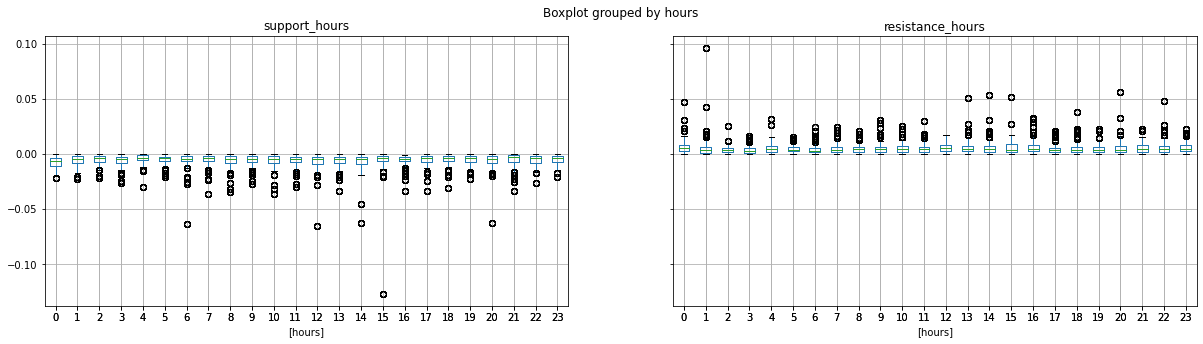

In [27]:
data.boxplot(column=['support_hours', 'resistance_hours'], by=['hours'], figsize=(20,5))

array([<AxesSubplot:title={'center':'support_days'}, xlabel='[daysWeek]'>,
       <AxesSubplot:title={'center':'resistance_days'}, xlabel='[daysWeek]'>],
      dtype=object)

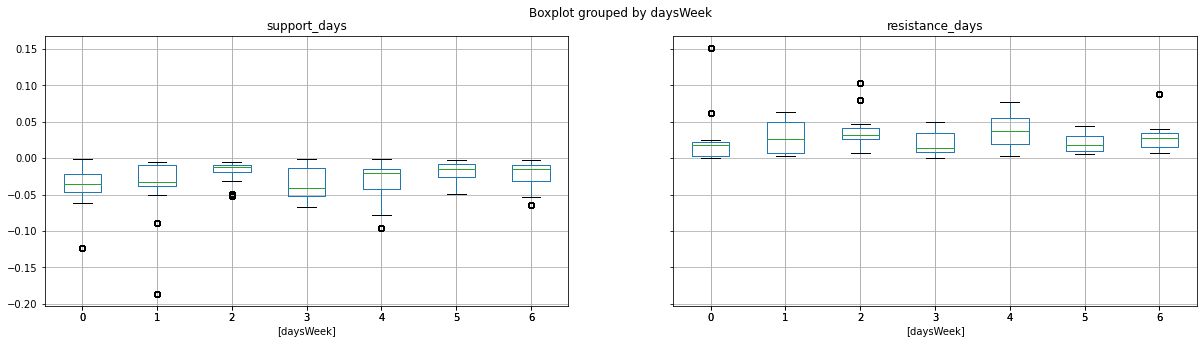

In [28]:
data.boxplot(column=['support_days', 'resistance_days'], by=['daysWeek'], figsize=(20,5))

<AxesSubplot:title={'center':'cumsum_hours'}, xlabel='[hours]'>

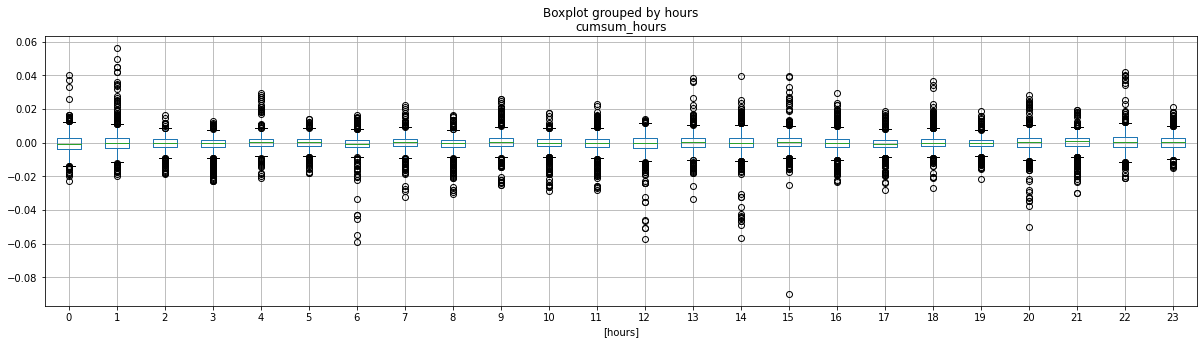

In [39]:
data.boxplot(column=['cumsum_hours'], by=['hours'], figsize=(20,5))

<AxesSubplot:title={'center':'cumsum_days'}, xlabel='[daysWeek]'>

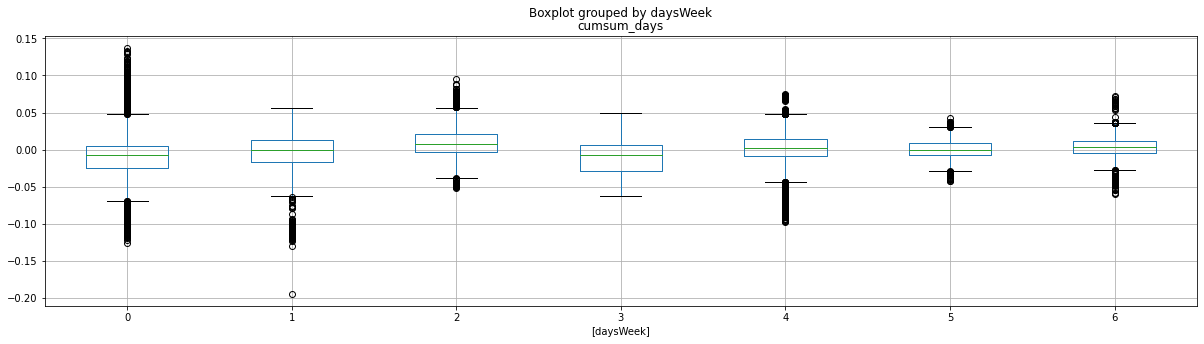

In [31]:
data.boxplot(column=['cumsum_days'], by=['daysWeek'], figsize=(20,5))

In [65]:
for i in range(23):
    print(i, data[data['hours'] == i]['cumsum_hours'].mean())

0 -0.0003959997789385217
1 0.0003966098756028705
2 -0.00030465912845852424
3 -0.0010780203701628572
4 0.0005692260574611179
5 0.00022312468441833115
6 -0.0005942003228981372
7 0.0001008563885093661
8 -0.0006942819407174206
9 0.0003537522668176896
10 -0.0004534683037612802
11 -0.0001804686525177279
12 -0.00039528243977723557
13 0.00031496991914358645
14 -0.00032844537665223036
15 0.0008270212111665093
16 1.4884531261432458e-05
17 -0.00045852454016144967
18 0.0003153577732394198
19 -0.00010717531151836138
20 -5.595025978357166e-06
21 0.0004102648924593223
22 0.000571399895693901


In [56]:
levels = {}
levels_day = {}
for i in hours:
    keys = {'support': data[data['hours'] == i]['support_hours'].median(),
            'resistance': data[data['hours'] == i]['resistance_hours'].median()}
    levels[i] = keys
for i in days_week:
    keys = {'support': data[data['daysWeek'] == i]['support_days'].median(),
            'resistance': data[data['daysWeek'] == i]['resistance_days'].median()}
    levels_day[i] = keys


<AxesSubplot:xlabel='time'>

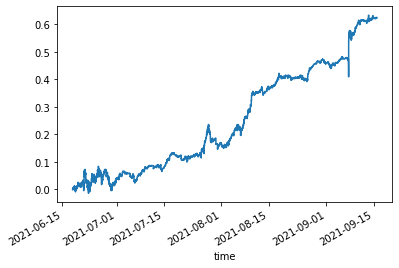

In [68]:
SIGMA = 1
data.loc[:, 'signal'] = 0

for i, v in data.iterrows():
    if  v['cumsum_hours'] <= levels[v['hours']].get('support') * SIGMA:
        data.loc[i, 'signal'] = 1
    if v['cumsum_hours'] >= levels[v['hours']].get('resistance') * SIGMA:
        data.loc[i, 'signal'] = -1
back = Backtest()
returns = back.exit_by_lag(data=data, take_profit=0.003, stop_loss=-0.003, lag=1, comission=0)
returns['cumsum'].plot()


<AxesSubplot:title={'center':'return'}, xlabel='[hours]'>

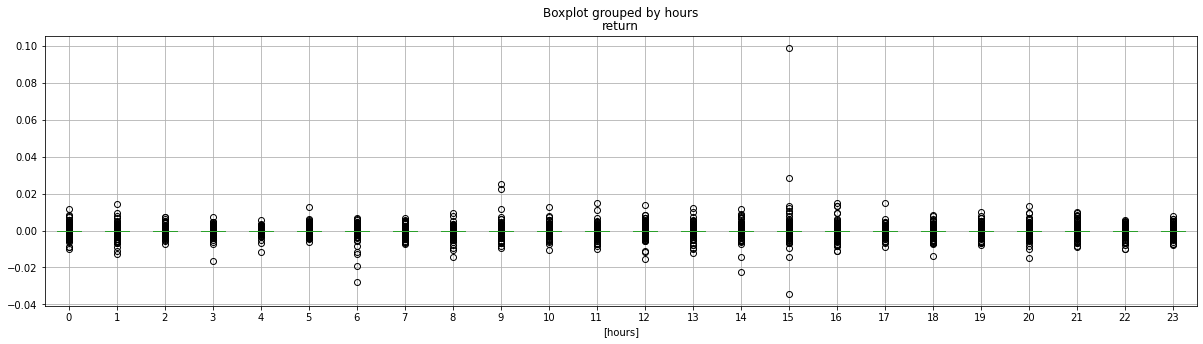

In [69]:
returns.boxplot(column=['return'], by=['hours'], figsize=(20,5))

In [71]:
reward = returns[returns['return'] > 0]['return'].count() / returns[returns['return'] < 0]['return'].count()
returns['return'].mean() * 100
# print(reward)

0.002408388214207097

<AxesSubplot:xlabel='time'>

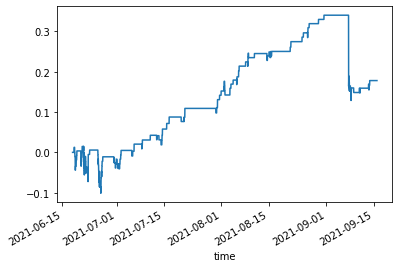

In [55]:
SIGMA = 1
data.loc[:, 'signal'] = 0

for i, v in data.iterrows():
    if  v['cumsum_days'] <= levels_day[v['daysWeek']].get('support') * SIGMA:
        data.loc[i, 'signal'] = 1
    # if v['cumsum_days'] >= levels_day[v['daysWeek']].get('resistance') * SIGMA:
    #     data.loc[i, 'signal'] = -1
back = Backtest()
returns = back.exit_by_take(data=data, take_profit=0.01, stop_loss=-0.01, comission=0)
returns['cumsum'].plot()


In [45]:
levels_day

{}